# Data Transformation

In [170]:
from dotenv import load_dotenv
load_dotenv()

True

In [171]:
import os
import pandas as pd

base_path = os.path.dirname(os.getcwd())
file_path = os.path.join(base_path,os.getenv("RAWDATA"))
quarter_path = os.path.join(base_path,os.getenv("Q_DATA"))

sheet_name = "月" 

df = pd.read_excel(file_path, sheet_name=sheet_name)
data_set={}
table_names=df.columns
for num in range(1,len(table_names)):
    avg_lsit=[]
    for data_num in range(0,len(df[table_names[num]]),3):
        data_avg=df[table_names[num]][data_num]+df[table_names[num]][data_num+1]+df[table_names[num]][data_num+2]/3
        avg_lsit.append(data_avg)
    data_set[table_names[num]]=avg_lsit

df_gdp = pd.DataFrame.from_dict(data_set)
df_gdp.to_csv(quarter_path, index=False, float_format='%.2f')  

# Data Consolidation

In [172]:
final_path = os.path.join(base_path,os.getenv("TRAINDATA"))
sheet_name = "季" 

df = pd.read_excel(file_path, sheet_name=sheet_name)
df_t=pd.read_csv(quarter_path)

if len(df) == len(df_t):
    df_merged = pd.concat([df, df_t], axis=1)  
    print(df_merged.head())  
else:
    print("兩個 DataFrame 的行數不同，無法合併")

df_merged.to_csv(final_path, index=False, float_format='%.2f')  

       年份     GDP  平均匯率(元/美元)  國內投資毛額    投資率  工業生產指數  製造業銷售量指數  \
0  71年第1季  461774       37.91  102048  22.10   27.57     30.02   
1  71年第2季  488234       38.78  143589  29.41   30.35     33.54   
2  71年第3季  489504       39.65  117934  24.09   30.06     32.76   
3  71年第4季  498511       40.15  144192  28.92   29.86     32.70   
4  72年第1季  495361       39.97   99632  20.11   29.28     31.80   

   電力(企業)總用電量(十億度)  進口物價基本分類指數  出口物價基本分類指數     進口貿易總值     出口貿易總值  \
0             4.85      231.63      311.21  147089.00  135223.67   
1             5.46      231.87      315.17  172059.67  156827.00   
2             5.81      234.50      317.22  181502.67  148698.00   
3             5.66      234.53      315.38  168145.00  135928.00   
4             5.21      227.62      309.54  153110.00  131671.00   

   機械及電機設備進口值(十億元)  消費者物價指數   失業率  就業人數（千人）  總人口數(千人)  景氣領先指標綜合指數(點)  \
0              0.0   129.59  3.42  15826.00  42389.67          28.72   
1              0.0   130.53  4.12  15577.33  42570

# X & Y dataset

In [173]:
x_path = os.path.join(base_path,os.getenv("X_LABEL"))
y_path = os.path.join(base_path,os.getenv("Y_LABEL"))

In [174]:
# 將「年份」欄位拆解成「年份」與「季別」
df_merged[['年份', '季別']] = df_merged['年份'].str.extract(r'(?P<年份>\d+)年第(?P<季別>\d)季')

# 將年份轉成西元（例如民國71年 → 西元1982年）
df_merged['年份'] = df_merged['年份'].astype(int) + 1911
df_merged['季別'] = df_merged['季別'].astype(int)


# 調整欄位順序：把 年份 和 季別 放在前面
df_cols = ['年份', '季別'] + [col for col in df_merged.columns if col not in ['年份', '季別', 'GDP']]
df_merged = df_merged[['年份', '季別', 'GDP'] + df_cols[2:]]



In [175]:
# 儲存 y.csv（只有 年份、季別、GDP）
df_merged[['年份', '季別', 'GDP']].to_csv(y_path, index=False)

# 儲存 x.csv（年份、季別 + 其他欄位，不含 GDP）
df_merged.drop(columns=['GDP']).to_csv(x_path, index=False)

# Model

## ARIMA

In [124]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [125]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


### ARIMA train and test data

In [178]:
arima_y_df = pd.read_csv(y_path)

In [180]:
# 時間切割
arima_train_y = arima_y_df[arima_y_df['年份'] <= 2016].copy()
arima_test_y = arima_y_df[arima_y_df['年份'] >= 2017].copy()

### ARIMA basic parament 

In [372]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# 將年份與季別合併成 datetime 格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 日期處理
arima_train_y['日期'] = arima_train_y.apply(quarter_to_date, axis=1)
arima_test_y['日期'] = arima_test_y.apply(quarter_to_date, axis=1)
arima_train_y.set_index('日期', inplace=True)
arima_test_y.set_index('日期', inplace=True)

# 串接資料方便使用
full_data = pd.concat([arima_train_y, arima_test_y])
full_data = full_data.sort_index()

# 建立預測清單
forecast_list = []
forecast_index = []

# 開始逐筆預測（用前3季預測下一季）
for date in arima_test_y.index:
    # 取出當前測試季之前的所有資料
    current_position = full_data.index.get_loc(date)
    if current_position < 3:
        continue  # 沒有足夠資料跳過

    # 抓前三季資料來建模
    train_window = full_data['GDP'].iloc[current_position - 3: current_position]
    model = ARIMA(train_window, order=(1, 1, 1))
    fitted_model = model.fit()
    
    forecast = fitted_model.forecast(steps=1)
    forecast_list.append(forecast.iloc[0])
    forecast_index.append(date)

# 預測結果整理成 Series
forecast_series = pd.Series(forecast_list, index=forecast_index)

# 建立訓練集預測清單
train_forecast_list = []
train_forecast_index = []

# 對訓練集做逐筆預測（從第4筆開始，用前3季預測）
for i in range(3, len(arima_train_y)):
    train_window = arima_train_y['GDP'].iloc[i - 3:i]
    model = ARIMA(train_window, order=(1, 1, 1))
    fitted_model = model.fit()
    
    forecast = fitted_model.forecast(steps=1)
    train_forecast_list.append(forecast.iloc[0])
    train_forecast_index.append(arima_train_y.index[i])

# 預測結果整理成 Series
train_forecast_series = pd.Series(train_forecast_list, index=train_forecast_index)



findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

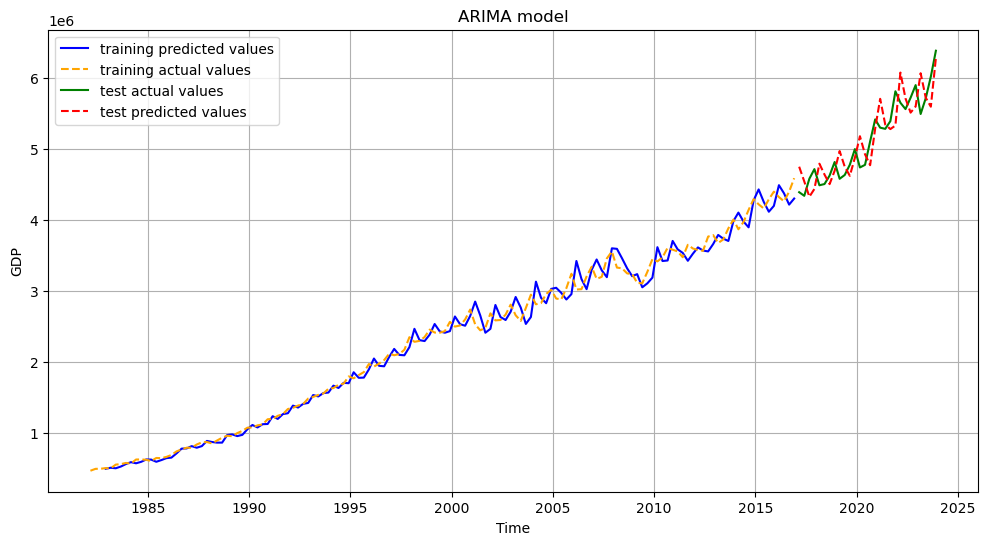

In [373]:
# 畫圖
plt.figure(figsize=(12, 6))

plt.plot(train_forecast_series, label='training predicted values',color='blue')
plt.plot(arima_train_y['GDP'], label='training actual values', color='orange',linestyle='--')
plt.plot(arima_test_y['GDP'], label='test actual values', color='green')
plt.plot(forecast_series, label='test predicted values', color='red',linestyle='--')

plt.legend()
plt.title('ARIMA model')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.grid(True)
plt.show()

In [ ]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [ ]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


### ARIMA MSE、RMSE、MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# === 測試集誤差（逐步預測）===
test_actual = arima_test_y['GDP']
test_pred = forecast_series

# 對齊 index（保險起見）
test_actual_aligned, test_pred_aligned = test_actual.align(test_pred, join='inner')

# 計算測試集誤差
test_mse = mean_squared_error(test_actual_aligned, test_pred_aligned)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_actual_aligned, test_pred_aligned)

# === 訓練集誤差（使用整個 arima_train_y 訓練一次模型）===
train_series = arima_train_y['GDP']
train_model = ARIMA(train_series, order=(1, 1, 1))
train_fitted_model = train_model.fit()

train_actual = train_series
train_pred = train_fitted_model.fittedvalues

# 對齊 index
train_actual_aligned, train_pred_aligned = train_actual.align(train_pred, join='inner')

# 計算訓練集誤差
train_mse = mean_squared_error(train_actual_aligned, train_pred_aligned)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_actual_aligned, train_pred_aligned)

# === 顯示結果 ===
print("📘 訓練集誤差（整段 ARIMA 拟合）:")
print(f"  MSE:  {train_mse:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")

print("\n🔍 測試集誤差（逐步預測）:")
print(f"  MSE:  {test_mse:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")


📘 訓練集誤差（整段 ARIMA 拟合）:
  MSE:  10116444032.29
  RMSE: 100580.54
  MAE:  73203.37

🔍 測試集誤差（逐步預測）:
  MSE:  81333953568.27
  RMSE: 285191.08
  MAE:  245486.83


### ARIMA with BayesianOptimization 

In [ ]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [377]:
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 建立 auto_arima 模型（用訓練資料）
model = auto_arima(
    train_series,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None, max_d=2,
    seasonal=False,         # 如果是季節性資料，改成 True
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",  # 忽略無效組合錯誤
    trace=True
)

# 顯示最佳參數
best_order = model.order
print(f"\n🔍 auto_arima 最佳參數: {best_order}")

# 預測測試集
forecast_test = model.predict(n_periods=len(arima_test_y))
test_actual = arima_test_y['GDP']
test_pred = pd.Series(forecast_test, index=arima_test_y.index)

# 訓練集預測（fittedvalues）
train_actual = train_series
train_pred = pd.Series(model.predict_in_sample(), index=train_series.index)
train_actual_aligned, train_pred_aligned = train_actual.align(train_pred, join='inner')

# === 計算誤差指標 ===
# 測試集
test_mse = mean_squared_error(test_actual, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_actual, test_pred)

# 訓練集
train_mse = mean_squared_error(train_actual_aligned, train_pred_aligned)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_actual_aligned, train_pred_aligned)

print(f"\n📈 測試集 RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")
print(f"📉 訓練集 RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3567.767, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3569.345, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3564.768, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3580.300, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3566.564, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3546.057, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3548.140, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3540.604, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3536.268, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3478.416, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3478.136, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3533.816, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3472.068, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3503.065, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

In [379]:
# 顯示結果
print("\n📘 訓練集誤差:")
print(f"  MSE:  {train_mse:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")

print("\n🔍 測試集誤差:")
print(f"  MSE:  {test_mse:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")


📘 訓練集誤差:
  MSE:  4745271931.25
  RMSE: 68885.93
  MAE:  43520.97

🔍 測試集誤差:
  MSE:  145698342957.03
  RMSE: 381704.52
  MAE:  284702.51


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

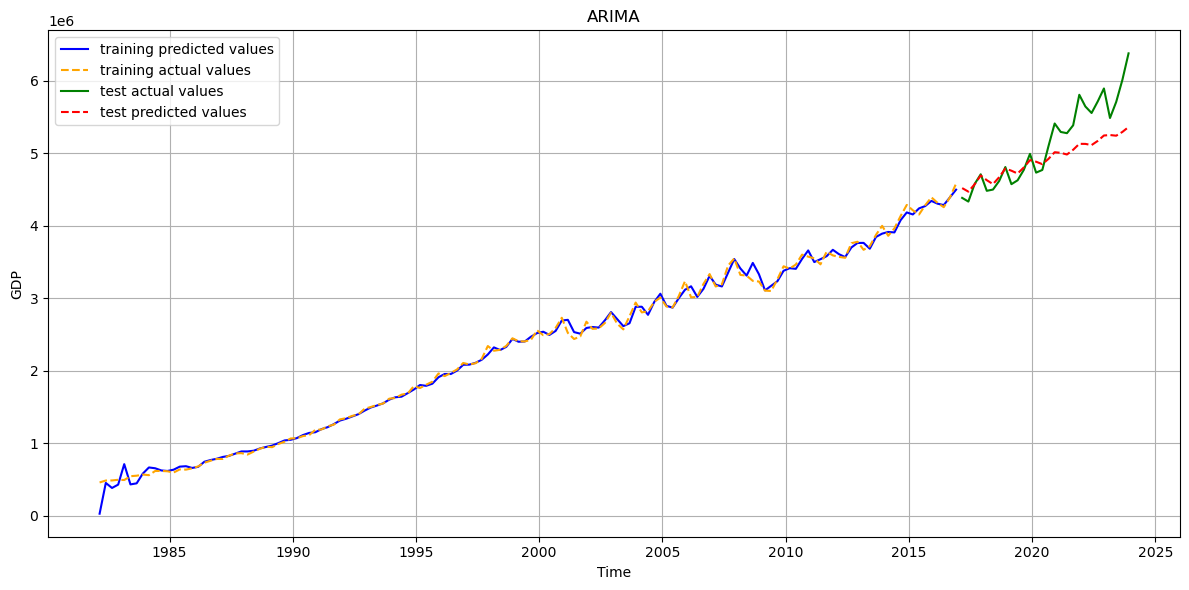

In [380]:
# 畫圖：訓練集、測試集實際值 & 測試集預測值
plt.figure(figsize=(12, 6))
plt.plot(train_pred, label='training predicted values',color='blue')
plt.plot(arima_train_y['GDP'], label='training actual values', color='orange',linestyle='--')

plt.plot(arima_test_y['GDP'], label='test actual values', color='green')
plt.plot(test_pred, label='test predicted values', color='red',linestyle='--')
plt.title('ARIMA')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# GB

In [353]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 載入資料
y_df = pd.read_csv(y_path)  # 包含年份、季、GDP
x_df = pd.read_csv(x_path)  # 包含年份、季、其他特徵

# 合併成一個 DataFrame
df = pd.merge(y_df, x_df, on=["年份", "季別"])
df = df.sort_values(by=["年份", "季別"]).reset_index(drop=True)

# 創建季數索引，方便滾動窗口
df['季數索引'] = range(len(df))

# 創建滾動式樣本，用前三季預測當季
X, y = [], []

for i in range(3, len(df)):
    # 取前三季特徵（flatten）
    features = df.loc[i-3:i-1, x_df.columns.drop(['年份', '季別'])].values.flatten()
    X.append(features)
    y.append(df.loc[i, "GDP"])

X = np.array(X)
y = np.array(y)


# 拆分成訓練 / 測試集（使用時間切割）# 拆分成訓練 / 測試集（使用時間切割）
train_size = int(len(X) * 0.8)
gb_train_x, gb_test_x = X[:train_size], X[train_size:]
gb_train_y, gb_test_y = y[:train_size], y[train_size:]

In [359]:
# 建立模型並訓練
model = GradientBoostingRegressor()
model.fit(gb_train_x, gb_train_y)

# 預測
gb_y_train_pred = model.predict(gb_train_x)
gb_y_test_pred = model.predict(gb_test_x)

# 評估
def eval_metrics(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} ➤ MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return mse, rmse, mae

print("\n📊 訓練集表現：")
eval_metrics(gb_train_y, gb_y_train_pred, "Train")

print("\n📊 測試集表現：")
eval_metrics(gb_test_y, gb_y_test_pred, "Test")



📊 訓練集表現：
Train ➤ MSE: 15942938.98, RMSE: 3992.86, MAE: 3032.23

📊 測試集表現：
Test ➤ MSE: 1004034706755.25, RMSE: 1002015.32, MAE: 800598.32


(1004034706755.246, 1002015.3226150017, 800598.3216492701)

In [360]:
gb_data_df=pd.DataFrame(x_df, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
gb_data_df['日期'] = gb_data_df.apply(quarter_to_date, axis=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

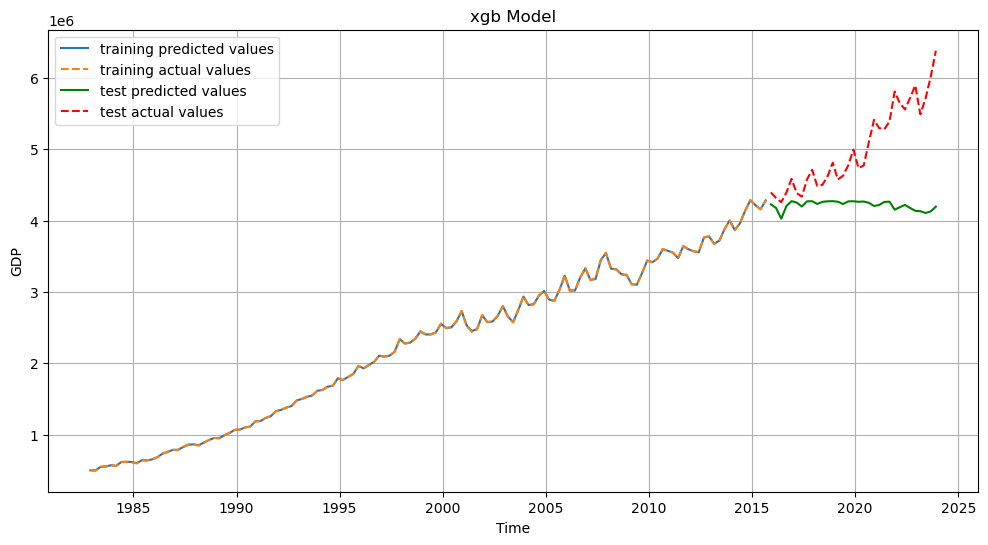

In [361]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(gb_data_df['日期'][3:135], gb_y_train_pred, label='training predicted values')
plt.plot(gb_data_df['日期'][3:135], gb_train_y, label='training actual values', linestyle='--')
plt.plot(gb_data_df['日期'][135:], gb_y_test_pred, label='test predicted values', color='green')
plt.plot(gb_data_df['日期'][135:], gb_test_y, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('xgb Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()


In [363]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- 假設你已經建立以下變數：
# X_train, X_test, y_train, y_test
# （來自於前面用前三季預測第四季的處理）

# 定義超參數空間
space = [
    Integer(50, 300, name='n_estimators'),
    Real(0.01, 0.3, name='learning_rate'),
    Integer(3, 10, name='max_depth'),
    Integer(2, 20, name='min_samples_split'),
    Integer(1, 20, name='min_samples_leaf')
]

# 目標函數（最小化測試集 MSE）
@use_named_args(space)
def objective(**params):
    model = GradientBoostingRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    model.fit(gb_train_x, gb_train_y)
    pred = model.predict(gb_test_x)
    mse = mean_squared_error(gb_test_y, pred)
    return mse  # 越小越好

# 執行貝式優化
result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=50,
    n_random_starts=5,
    random_state=42,
    verbose=True
)

# 最佳參數
best_params = {
    'n_estimators': result.x[0],
    'learning_rate': result.x[1],
    'max_depth': result.x[2],
    'min_samples_split': result.x[3],
    'min_samples_leaf': result.x[4]
}

# 使用最佳參數重新訓練模型
best_model = GradientBoostingRegressor(
    **best_params,
    random_state=42
)
best_model.fit(gb_train_x, gb_train_y)

# 預測
y_train_pred = best_model.predict(gb_train_x)
y_test_pred = best_model.predict(gb_test_x)

# 評估指標
train_mse = mean_squared_error(gb_train_y, gb_y_train_pred)
test_mse = mean_squared_error(gb_test_y, gb_y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(gb_train_y, gb_y_train_pred)
test_mae = mean_absolute_error(gb_test_y, gb_y_test_pred)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6134
Function value obtained: 955584670111.0717
Current minimum: 955584670111.0717
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1292
Function value obtained: 1154196657830.8630
Current minimum: 955584670111.0717
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0868
Function value obtained: 1359303138891.4341
Current minimum: 955584670111.0717
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2941
Function value obtained: 1031629675510.0310
Current minimum: 955584670111.0717
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5807


In [364]:
# 輸出結果
print("\n📊 最佳參數：")
for k, v in best_params.items():
    print(f"{k}: {v}")

print("\n📈 訓練集表現：")
print(f"MSE: {train_mse:.2f}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")

print("\n📈 測試集表現：")
print(f"MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")


📊 最佳參數：
n_estimators: 227
learning_rate: 0.16654869773825326
max_depth: 10
min_samples_split: 2
min_samples_leaf: 5

📈 訓練集表現：
MSE: 15942938.98, RMSE: 3992.86, MAE: 3032.23

📈 測試集表現：
MSE: 1004034706755.25, RMSE: 1002015.32, MAE: 800598.32


In [365]:
gb_data_df=pd.DataFrame(x_df, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
gb_data_df['日期'] = gb_data_df.apply(quarter_to_date, axis=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

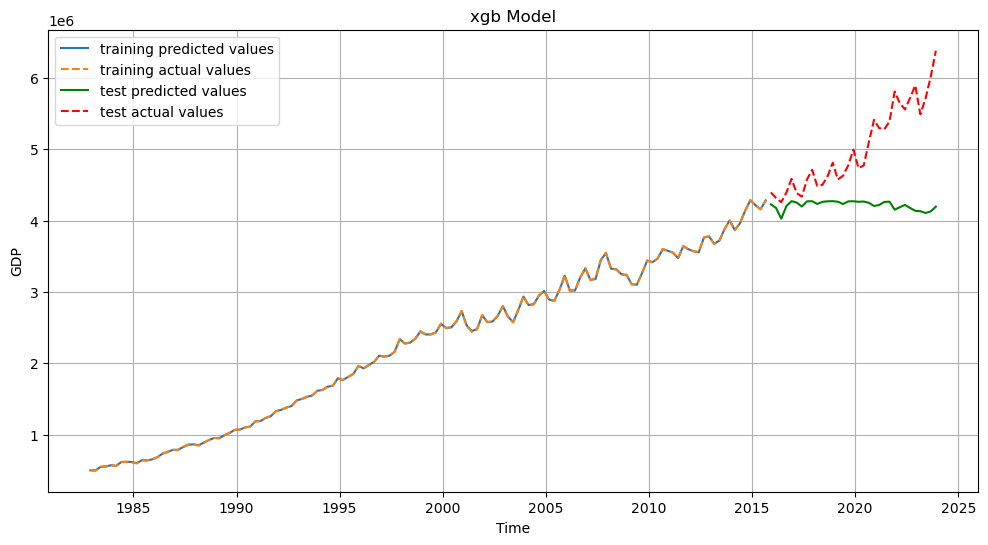

In [366]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(gb_data_df['日期'][3:135], gb_y_train_pred, label='training predicted values')
plt.plot(gb_data_df['日期'][3:135], gb_train_y, label='training actual values', linestyle='--')
plt.plot(gb_data_df['日期'][135:], gb_y_test_pred, label='test predicted values', color='green')
plt.plot(gb_data_df['日期'][135:], gb_test_y, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('xgb Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()


# xgboost

In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 載入資料
y_df = pd.read_csv(y_path)  # 包含年份、季、GDP
x_df = pd.read_csv(x_path)  # 包含年份、季、其他特徵

# 合併成一個 DataFrame
df = pd.merge(y_df, x_df, on=["年份", "季別"])
df = df.sort_values(by=["年份", "季別"]).reset_index(drop=True)

# 創建季數索引，方便滾動窗口
df['季數索引'] = range(len(df))

# 創建滾動式樣本，用前三季預測當季
X, y = [], []

for i in range(3, len(df)):
    # 取前三季特徵（flatten）
    features = df.loc[i-3:i-1, x_df.columns.drop(['年份', '季別'])].values.flatten()
    X.append(features)
    y.append(df.loc[i, "GDP"])

X = np.array(X)
y = np.array(y)

# 拆分成訓練 / 測試集（使用時間切割）# 拆分成訓練 / 測試集（使用時間切割）
train_size = int(len(X) * 0.8)
xg_train_x, xg_test_x = X[:train_size], X[train_size:]
xg_train_y, xg_test_y = y[:train_size], y[train_size:]

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(xg_train_x, xg_train_y)

xgb_train_pred = xgb_model.predict(xg_train_x)
xgb_test_pred = xgb_model.predict(xg_test_x)

xgb_train_mse = mean_squared_error(xg_train_y, xgb_train_pred)
xgb_test_mse = mean_squared_error(xg_test_y, xgb_test_pred)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_train_mae = mean_absolute_error(xg_train_y, xgb_train_pred)
xgb_test_mae = mean_absolute_error(xg_test_y, xgb_test_pred)

print("\n📊 XGBoost - 訓練集表現：")
print(f"MSE: {xgb_train_mse:.2f}, RMSE: {xgb_train_rmse:.2f}, MAE: {xgb_train_mae:.2f}")
print("\n📊 XGBoost - 測試集表現：")
print(f"MSE: {xgb_test_mse:.2f}, RMSE: {xgb_test_rmse:.2f}, MAE: {xgb_test_mae:.2f}")



📊 XGBoost - 訓練集表現：
MSE: 1.71, RMSE: 1.31, MAE: 0.87

📊 XGBoost - 測試集表現：
MSE: 955085293427.74, RMSE: 977284.65, MAE: 784520.91


In [345]:
xgb_data_df=pd.DataFrame(x_df, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
xgb_data_df['日期'] = xgb_data_df.apply(quarter_to_date, axis=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

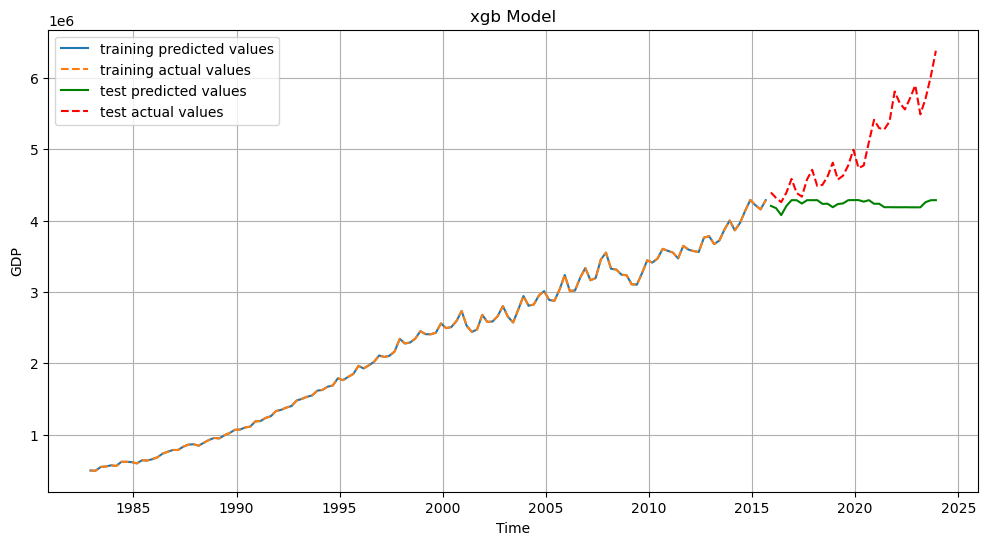

In [347]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(xgb_data_df['日期'][3:135], xgb_train_pred, label='training predicted values')
plt.plot(xgb_data_df['日期'][3:135], xg_train_y, label='training actual values', linestyle='--')
plt.plot(xgb_data_df['日期'][135:], xgb_test_pred, label='test predicted values', color='green')
plt.plot(xgb_data_df['日期'][135:], xg_test_y, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('xgb Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()


In [348]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from xgboost import XGBRegressor

# XGBoost 超參數空間
xgb_space = [
    Integer(50, 300, name='n_estimators'),
    Real(0.01, 0.3, name='learning_rate'),
    Integer(3, 10, name='max_depth')
]

@use_named_args(xgb_space)
def xgb_objective(**params):
    model = XGBRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        random_state=42,
        verbosity=0
    )
    model.fit(xg_train_x, xg_train_y)
    pred = model.predict(xg_test_x)
    return mean_squared_error(xg_test_y, pred)

xgb_result = gp_minimize(
    xgb_objective,
    xgb_space,
    n_calls=50,
    n_random_starts=5,
    random_state=42,
    verbose=True
)

best_xgb_params = {
    'n_estimators': xgb_result.x[0],
    'learning_rate': xgb_result.x[1],
    'max_depth': xgb_result.x[2]
}

# 重新訓練最佳 XGB
best_xgb = XGBRegressor(**best_xgb_params, random_state=42, verbosity=0)
best_xgb.fit(xg_train_x, xg_train_y)

xgb_train_pred = best_xgb.predict(xg_train_x)
xgb_test_pred = best_xgb.predict(xg_test_x)

# 評估
xgb_train_mse = mean_squared_error(xg_train_y, xgb_train_pred)
xgb_test_mse = mean_squared_error(xg_test_y, xgb_test_pred)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_train_mae = mean_absolute_error(xg_train_y, xgb_train_pred)
xgb_test_mae = mean_absolute_error(xg_test_y, xgb_test_pred)




Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3169
Function value obtained: 949420483247.5095
Current minimum: 949420483247.5095
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1694
Function value obtained: 977314391783.6041
Current minimum: 949420483247.5095
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2043
Function value obtained: 966313469887.7122
Current minimum: 949420483247.5095
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5446
Function value obtained: 985466266784.1818
Current minimum: 949420483247.5095
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8311
Fun

In [349]:
# 印出最佳參數
print("\n🔧 最佳 XGBoost 參數：")
print(f"n_estimators: {best_xgb_params['n_estimators']}")
print(f"learning_rate: {best_xgb_params['learning_rate']:.4f}")
print(f"max_depth: {best_xgb_params['max_depth']}")


🔧 最佳 XGBoost 參數：
n_estimators: 250
learning_rate: 0.2372
max_depth: 7


In [350]:
print("\n📊 最佳 XGBoost - 訓練集表現：")
print(f"MSE: {xgb_train_mse:.2f}, RMSE: {xgb_train_rmse:.2f}, MAE: {xgb_train_mae:.2f}")
print("\n📊 最佳 XGBoost - 測試集表現：")
print(f"MSE: {xgb_test_mse:.2f}, RMSE: {xgb_test_rmse:.2f}, MAE: {xgb_test_mae:.2f}")


📊 最佳 XGBoost - 訓練集表現：
MSE: 0.13, RMSE: 0.36, MAE: 0.29

📊 最佳 XGBoost - 測試集表現：
MSE: 920572025867.95, RMSE: 959464.45, MAE: 771551.83


In [351]:
xgb_data_df=pd.DataFrame(x_df, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
xgb_data_df['日期'] = xgb_data_df.apply(quarter_to_date, axis=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

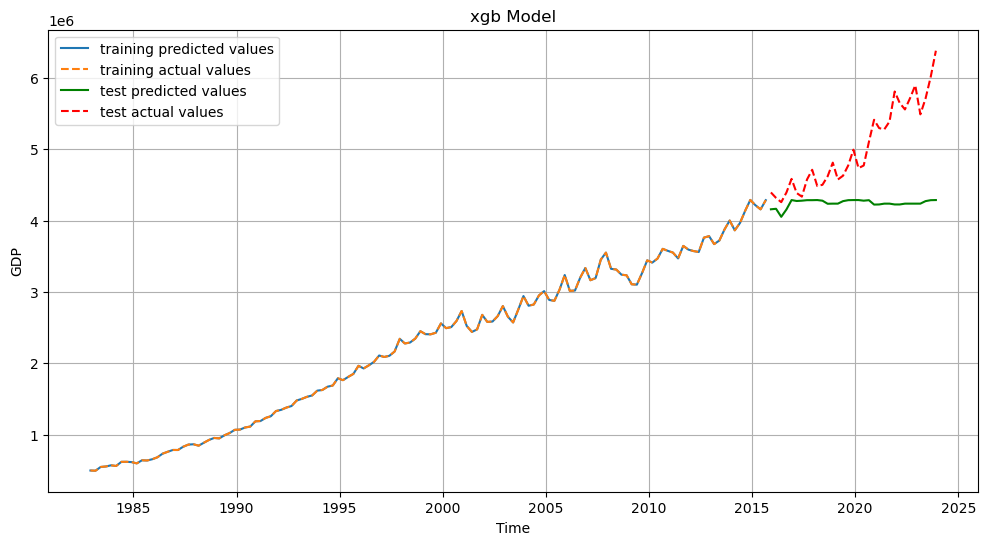

In [352]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(xgb_data_df['日期'][3:135], xgb_train_pred, label='training predicted values')
plt.plot(xgb_data_df['日期'][3:135], xg_train_y, label='training actual values', linestyle='--')
plt.plot(xgb_data_df['日期'][135:], xgb_test_pred, label='test predicted values', color='green')
plt.plot(xgb_data_df['日期'][135:], xg_test_y, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('xgb Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()

# RF

In [330]:
# 載入資料
y_df = pd.read_csv(y_path)  # 包含年份、季、GDP
x_df = pd.read_csv(x_path)  # 包含年份、季、其他特徵

# 合併成一個 DataFrame
df = pd.merge(y_df, x_df, on=["年份", "季別"])
df = df.sort_values(by=["年份", "季別"]).reset_index(drop=True)

# 創建季數索引，方便滾動窗口
df['季數索引'] = range(len(df))

# 創建滾動式樣本，用前三季預測當季
X, y = [], []

for i in range(3, len(df)):
    # 取前三季特徵（flatten）
    features = df.loc[i-3:i-1, x_df.columns.drop(['年份', '季別'])].values.flatten()
    X.append(features)
    y.append(df.loc[i, "GDP"])

X = np.array(X)
y = np.array(y)


# 拆分成訓練 / 測試集（使用時間切割）
train_size = int(len(X) * 0.8)
rf_train_x, rf_test_x = X[:train_size], X[train_size:]
rf_train_y, rf_test_y = y[:train_size], y[train_size:]

In [331]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(rf_train_x, rf_train_y)

rf_train_pred = rf_model.predict(rf_train_x)
rf_test_pred = rf_model.predict(rf_test_x)

rf_train_mse = mean_squared_error(rf_train_y, rf_train_pred)
rf_test_mse = mean_squared_error(rf_test_y, rf_test_pred)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_train_mae = mean_absolute_error(rf_train_y, rf_train_pred)
rf_test_mae = mean_absolute_error(rf_test_y, rf_test_pred)

print("\n📊 Random Forest - 訓練集表現：")
print(f"MSE: {rf_train_mse:.2f}, RMSE: {rf_train_rmse:.2f}, MAE: {rf_train_mae:.2f}")
print("\n📊 Random Forest - 測試集表現：")
print(f"MSE: {rf_test_mse:.2f}, RMSE: {rf_test_rmse:.2f}, MAE: {rf_test_mae:.2f}")


📊 Random Forest - 訓練集表現：
MSE: 803962804.40, RMSE: 28354.24, MAE: 21329.75

📊 Random Forest - 測試集表現：
MSE: 1097319343497.61, RMSE: 1047530.12, MAE: 858107.84


In [341]:
rf_data_df=pd.DataFrame(x_df, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
rf_data_df['日期'] = rf_data_df.apply(quarter_to_date, axis=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

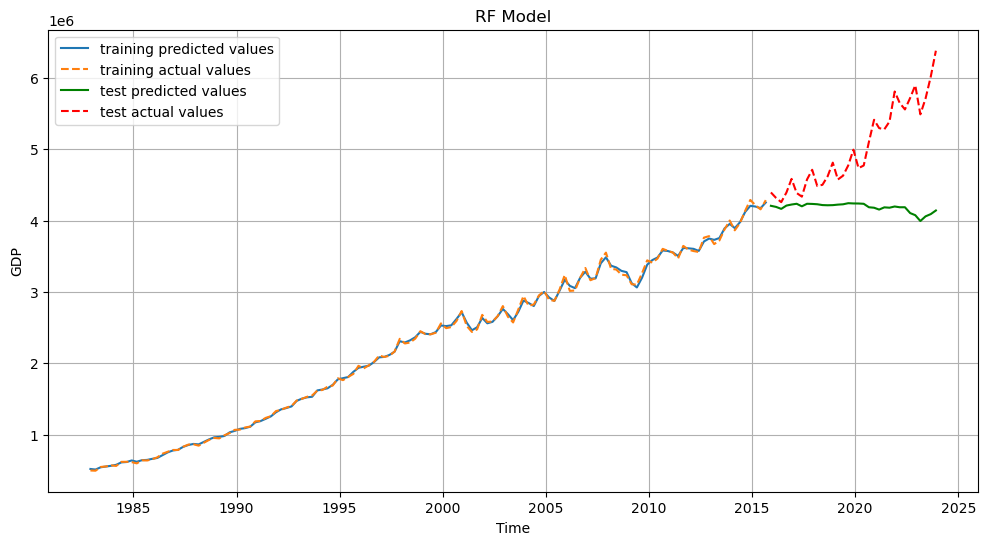

In [342]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(rf_data_df['日期'][3:135], rf_train_pred, label='training predicted values')
plt.plot(rf_data_df['日期'][3:135], rf_train_y, label='training actual values', linestyle='--')
plt.plot(rf_data_df['日期'][135:], rf_test_pred, label='test predicted values', color='green')
plt.plot(rf_data_df['日期'][135:], rf_test_y, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('RF Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

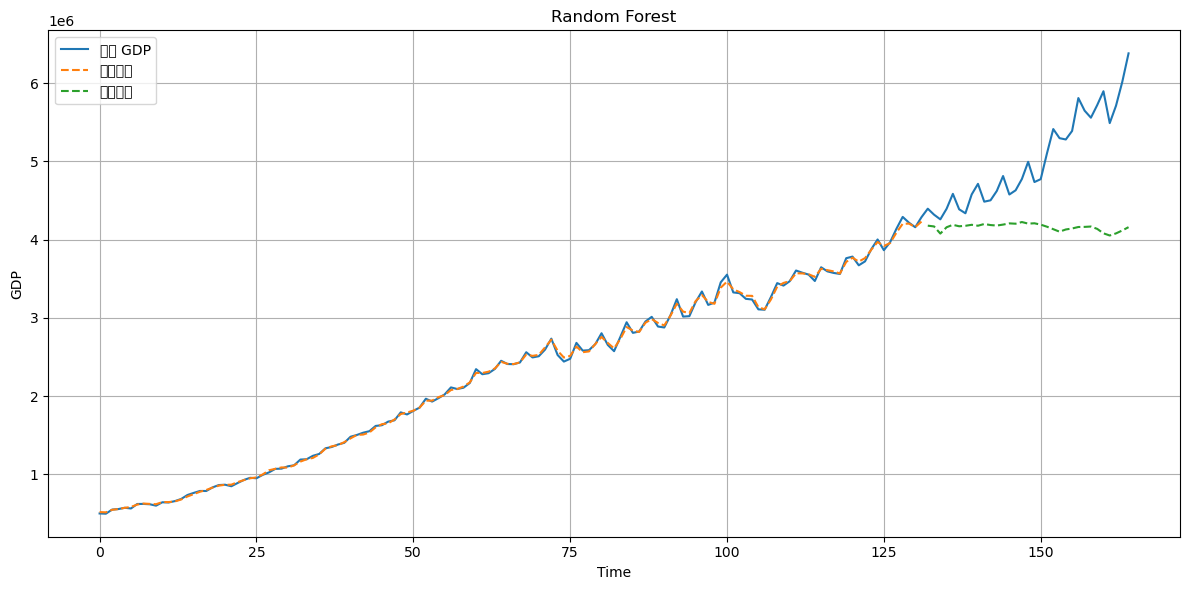

In [332]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y, label="真實 GDP")
plt.plot(range(len(rf_train_pred)), rf_train_pred, label="訓練預測", linestyle="--")
plt.plot(range(len(rf_train_pred), len(y)), rf_test_pred, label="測試預測", linestyle="--")

plt.legend()
plt.title("Random Forest")
plt.xlabel("Time")
plt.ylabel("GDP")
plt.grid(True)
plt.tight_layout()
plt.show()

In [335]:
# RF 超參數空間
rf_space = [
    Integer(50, 300, name='n_estimators'),
    Integer(3, 20, name='max_depth'),
    Integer(1, 20, name='min_samples_leaf')
]

@use_named_args(rf_space)
def rf_objective(**params):
    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    model.fit(rf_train_x, rf_train_y)
    pred = model.predict(rf_test_x)
    return mean_squared_error(rf_test_y, pred)

rf_result = gp_minimize(
    rf_objective,
    rf_space,
    n_calls=50,
    n_random_starts=5,
    random_state=42,
    verbose=True
)

best_rf_params = {
    'n_estimators': rf_result.x[0],
    'max_depth': rf_result.x[1],
    'min_samples_leaf': rf_result.x[2]
}

# 重新訓練最佳 RF
best_rf = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf.fit(rf_train_x, rf_train_y)

rf_train_pred = best_rf.predict(rf_train_x)
rf_test_pred = best_rf.predict(rf_test_x)

rf_train_mse = mean_squared_error(rf_train_y, rf_train_pred)
rf_test_mse = mean_squared_error(rf_test_y, rf_test_pred)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_train_mae = mean_absolute_error(rf_train_y, rf_train_pred)
rf_test_mae = mean_absolute_error(rf_test_y, rf_test_pred)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2962
Function value obtained: 2331173136460.0737
Current minimum: 2331173136460.0737
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3666
Function value obtained: 1172372749512.9316
Current minimum: 1172372749512.9316
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2835
Function value obtained: 1244405275608.6731
Current minimum: 1172372749512.9316
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3215
Function value obtained: 2332735723943.6997
Current minimum: 1172372749512.9316
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.

In [334]:
# 印出最佳參數
print("\n🔧 最佳 Random Forest 參數：")
print(f"n_estimators: {best_rf_params['n_estimators']}")
print(f"max_depth: {best_rf_params['max_depth']}")
print(f"min_samples_leaf: {best_rf_params['min_samples_leaf']}")



🔧 最佳 Random Forest 參數：
n_estimators: 300
max_depth: 20
min_samples_leaf: 1


In [336]:
print("\n📊 最佳 RF - 訓練集表現：")
print(f"MSE: {rf_train_mse:.2f}, RMSE: {rf_train_rmse:.2f}, MAE: {rf_train_mae:.2f}")
print("\n📊 最佳 RF - 測試集表現：")
print(f"MSE: {rf_test_mse:.2f}, RMSE: {rf_test_rmse:.2f}, MAE: {rf_test_mae:.2f}")


📊 最佳 RF - 訓練集表現：
MSE: 752822633.03, RMSE: 27437.61, MAE: 20861.81

📊 最佳 RF - 測試集表現：
MSE: 1074397128535.92, RMSE: 1036531.30, MAE: 831538.91


In [337]:
rf_data_df=pd.DataFrame(x_df, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
rf_data_df['日期'] = rf_data_df.apply(quarter_to_date, axis=1)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

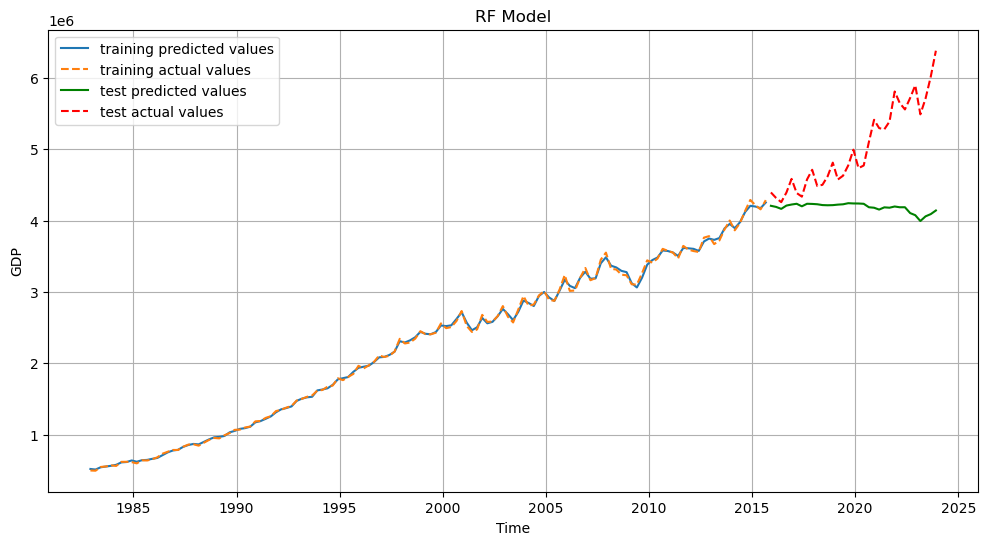

In [340]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(rf_data_df['日期'][3:135], rf_train_pred, label='training predicted values')
plt.plot(rf_data_df['日期'][3:135], rf_train_y, label='training actual values', linestyle='--')
plt.plot(rf_data_df['日期'][135:], rf_test_pred, label='test predicted values', color='green')
plt.plot(rf_data_df['日期'][135:], rf_test_y, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('RF Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()


# LSTM

In [ ]:
pip install keras

In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
import gc


In [79]:
lstm_data=pd.read_csv(final_path)

In [81]:
lstm_data[['年份', '季別']] = lstm_data['年份'].str.extract(r'(?P<年份>\d+)年第(?P<季別>\d)季')
# 將年份轉成西元（例如民國71年 → 西元1982年）
lstm_data['年份'] = lstm_data['年份'].astype(int) + 1911
lstm_data['季別'] = lstm_data['季別'].astype(int)

In [88]:
target_col = 'GDP'
feature_cols = [col for col in lstm_data.columns if col not in ['年份', '季別', target_col]]

In [91]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(lstm_data[feature_cols])
y_scaled = scaler_y.fit_transform(lstm_data[[target_col]])


In [92]:

def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])  # 前三季
        ys.append(y[i])  # 第四季
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=3)


In [222]:
train_size = int(len(X_seq) * 0.8)
lstm_X_train, lstm_X_test = X_seq[:train_size], X_seq[train_size:]
lstm_y_train, lstm_y_test = y_seq[:train_size], y_seq[train_size:]


In [223]:
model = Sequential()
model.add(LSTM(64, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=16, validation_data=(lstm_X_test, lstm_y_test))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0673 - val_loss: 0.0038
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - val_loss: 0.0173
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0405
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7672e-04 - val_loss: 0.0157
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1869e-04 - val_loss: 0.0100
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2009e-04 - val_loss: 0.0113
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3932e-04 - val_loss: 0.0109
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4061e-04 - val_loss: 0.0124
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3238e-04 - val_loss: 0.0123
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1808e-04 - v

In [224]:
y_pred_scaled_lstm = model.predict(lstm_X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm)
y_true_lstm = scaler_y.inverse_transform(lstm_y_test)

def evaluate_performance(y_true_scaled, y_pred_scaled, scaler, dataset_name=""):
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n📊 {dataset_name} Performance:")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


In [244]:
# 預測
y_train_pred_scaled = model.predict(lstm_X_train)
y_pred_lstm_train = scaler_y.inverse_transform(y_train_pred_scaled)
y_true_lstm_train = scaler_y.inverse_transform(lstm_y_train)


y_test_pred_scaled = model.predict(lstm_X_test)
y_pred_lstm_test = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_lstm_test = scaler_y.inverse_transform(lstm_y_test)


# 執行評估
evaluate_performance(lstm_y_train, y_train_pred_scaled, scaler_y, dataset_name="Train Set")
evaluate_performance(lstm_y_test, y_test_pred_scaled, scaler_y, dataset_name="Test Set")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📊 Train Set Performance:
  MSE:  8603505168.35
  RMSE: 92755.08
  MAE:  73783.40

📊 Test Set Performance:
  MSE:  265937124428.19
  RMSE: 515690.92
  MAE:  422676.62


In [ ]:
lstm_data_df=pd.DataFrame(lstm_data, columns=['年份', '季別'])

# 定義函數：將 '年份' 和 '季別' 轉換為日期格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

# 轉換訓練集和測試集的時間索引
lstm_data_df['日期'] = lstm_data_df.apply(quarter_to_date, axis=1)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

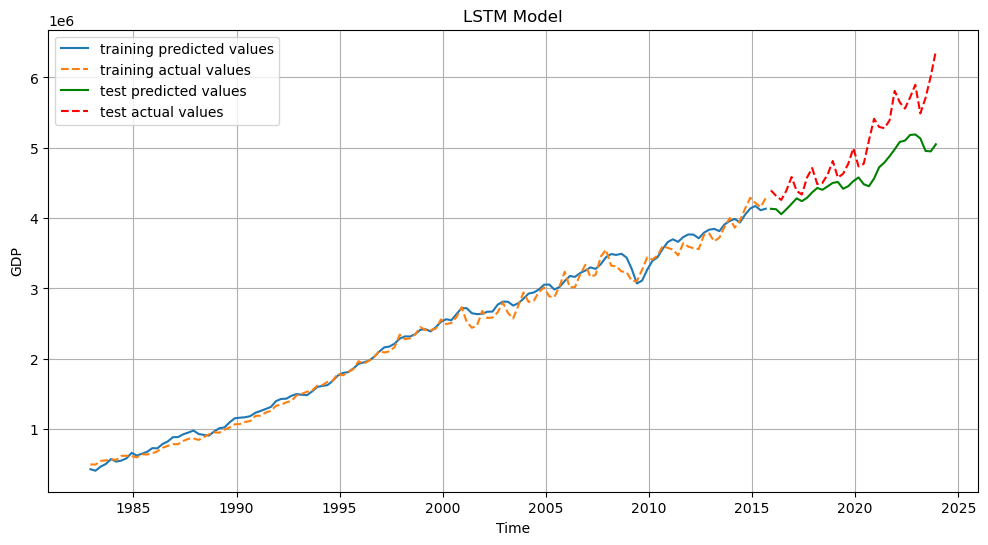

In [310]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(lstm_data_df['日期'][3:135], y_pred_lstm_train, label='training predicted values')
plt.plot(lstm_data_df['日期'][3:135], y_true_lstm_train, label='training actual values', linestyle='--')
plt.plot(lstm_data_df['日期'][135:], y_pred_lstm_test, label='test predicted values', color='green')
plt.plot(lstm_data_df['日期'][135:], y_true_lstm_test, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()


In [228]:
from tensorflow.keras.optimizers import Adam
from skopt import gp_minimize
import tensorflow as tf

In [229]:
# 定義搜尋空間
search_space = [
    Integer(16, 128, name='units'),
    Integer(16, 64, name='batch_size'),
    Integer(10, 100, name='epochs'),
    Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate')
]

# 你的訓練資料（使用你之前定義的 lstm_X_train, lstm_y_train）
input_shape = (lstm_X_train.shape[1], lstm_X_train.shape[2])

@use_named_args(search_space)
def objective(units, batch_size, epochs, learning_rate):
    tf.keras.backend.clear_session()
    
    # 強制轉換為 Python int
    units = int(units)
    batch_size = int(batch_size)
    epochs = int(epochs)

    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=learning_rate)
    )

    model.fit(
        lstm_X_train, lstm_y_train,
        validation_data=(lstm_X_test, lstm_y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    y_pred_scaled = model.predict(lstm_X_test)
    y_true = scaler_y.inverse_transform(lstm_y_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"units: {units}, batch: {batch_size}, epoch: {epochs}, lr: {learning_rate:.5f} → RMSE: {rmse:.2f}")
    return rmse



In [230]:
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    acq_func='EI',
    n_calls=50,
    n_random_starts=5,
    random_state=42,
    verbose=True
)


Iteration No: 1 started. Evaluating function at random point.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
units: 105, batch: 25, epoch: 80, lr: 0.00156 → RMSE: 365990.65
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.8636
Function value obtained: 365990.6506
Current minimum: 365990.6506
Iteration No: 2 started. Evaluating function at random point.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
units: 66, batch: 21, epoch: 51, lr: 0.00046 → RMSE: 637397.37
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.5247
Function value obtained: 637397.3669
Current minimum: 365990.6506
Iteration No: 3 started. Evaluating function at random point.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
units: 32, batch: 47, epoch: 15, lr: 0.00278 → RMSE: 586652.09
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.0893
Function value obtained: 586652.0915
Current minimum: 365990.6506
Iteration No: 4 started. Evaluating function at random point.
2/2 ━━━━━━━━━━━━━━━━━

In [ ]:
print("\n✅ 最佳參數組合:")
print(f"units: {result.x[0]}")
print(f"batch_size: {result.x[1]}")
print(f"epochs: {result.x[2]}")
print(f"learning_rate: {result.x[3]:.5f}")
print(f"Best RMSE: {result.fun:.2f}")


✅ 最佳參數組合:
units: 68
batch_size: 16
epochs: 100
learning_rate: 0.00010
Best RMSE: 317305.47


In [133]:
# 從 gp_minimize 結果中提取最佳參數
best_units = int(result.x[0])
best_batch_size = int(result.x[1])
best_epochs = int(result.x[2])
best_learning_rate = result.x[3]


In [134]:
# 清除前一個模型
tf.keras.backend.clear_session()

# 建立模型
model = Sequential()
model.add(LSTM(best_units, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
model.add(Dense(1))
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=best_learning_rate)
)

# 重新訓練模型
model.fit(
    lstm_X_train, lstm_y_train,
    epochs=best_epochs,
    batch_size=best_batch_size,
    validation_data=(lstm_X_test, lstm_y_test),
    verbose=1
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1028 - val_loss: 0.3841
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0727 - val_loss: 0.2719
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427 - val_loss: 0.1864
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249 - val_loss: 0.1238
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 0.0827
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0582
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0071 - val_loss: 0.0444
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0375
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0340
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0316
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0300
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0285

In [311]:
# 預測
y_train_pred_scaled = model.predict(lstm_X_train)
y_pred_lstm_train = scaler_y.inverse_transform(y_train_pred_scaled)
y_true_lstm_train = scaler_y.inverse_transform(lstm_y_train)


y_test_pred_scaled = model.predict(lstm_X_test)
y_pred_lstm_test = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_lstm_test = scaler_y.inverse_transform(lstm_y_test)

# 執行評估
evaluate_performance(lstm_y_train, y_train_pred_scaled, scaler_y, dataset_name="Train Set (Best Params)")
evaluate_performance(lstm_y_test, y_test_pred_scaled, scaler_y, dataset_name="Test Set (Best Params)")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

📊 Train Set (Best Params) Performance:
  MSE:  8603505168.35
  RMSE: 92755.08
  MAE:  73783.40

📊 Test Set (Best Params) Performance:
  MSE:  265937124428.19
  RMSE: 515690.92
  MAE:  422676.62


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

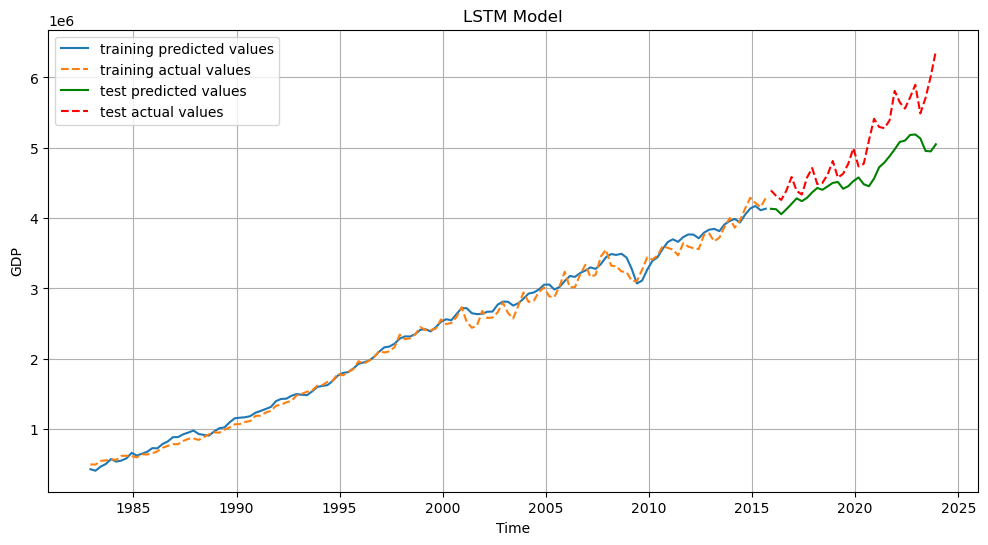

In [312]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# 畫出訓練集和測試集的預測與實際值
plt.plot(lstm_data_df['日期'][3:135], y_pred_lstm_train, label='training predicted values')
plt.plot(lstm_data_df['日期'][3:135], y_true_lstm_train, label='training actual values', linestyle='--')
plt.plot(lstm_data_df['日期'][135:], y_pred_lstm_test, label='test predicted values', color='green')
plt.plot(lstm_data_df['日期'][135:], y_true_lstm_test, label='test actual values', color='red', linestyle='--')

# 圖例和標題設定
plt.legend()
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('GDP')

# 顯示網格
plt.grid(True)

# 顯示圖形
plt.show()
